In [59]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings('ignore')

In [60]:
class Config:
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    TARGET_COL_NAME = "song_popularity"
    CATEGORICAL_COLS = ["audio_mode", "time_signature", "key"]

DATA_PATH = "./data/"

In [61]:
df_train = pd.read_csv(DATA_PATH + "train.csv")
df_test = pd.read_csv(DATA_PATH + "test.csv")

In [62]:
# split the training dataframe into kfolds for cross validation. We do this before any processing is done
# on the data. We use stratified kfold if the target distribution is unbalanced
def strat_kfold_dataframe(df, target_col_name, num_folds=5):
    # we create a new column called kfold and fill it with -1
    df["kfold"] = -1
    # randomize of shuffle the rows of dataframe before splitting is done
    df = df.sample(frac=1, random_state=Config.RANDOM_SEED).reset_index(drop=True)
    # get the target data
    y = df[target_col_name].values
    skf = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X=df, y=y)):
        df.loc[val_index, "kfold"] = fold    
    return df     

df_train = strat_kfold_dataframe(df_train, target_col_name=Config.TARGET_COL_NAME, num_folds=Config.NUM_FOLDS)
df_train.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,kfold
0,32823,144667.0,0.585599,0.691626,0.503891,0.222360,10.0,0.115524,-11.642316,0,0.049854,86.041825,3,0.539072,1,4
1,16298,203954.0,0.016664,0.667695,0.683820,0.001178,4.0,0.213299,NaN,1,0.102933,97.073546,3,0.667166,0,0
2,28505,179054.0,0.069471,0.624358,0.891436,0.000637,2.0,NaN,NaN,1,0.173795,140.102334,4,0.824423,0,1
3,6689,246074.0,0.333662,0.645299,0.716589,0.003159,2.0,0.114810,-9.178056,0,0.056690,101.694474,4,0.532739,1,3
4,26893,282403.0,0.378221,0.258557,0.617000,0.001366,7.0,0.172308,-6.721257,0,0.044904,123.402262,3,0.717549,0,1


In [63]:
cont_cols = ['song_duration_ms', 'acousticness', 'danceability', 'energy', 
            'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence']

In [64]:
def impute_df_col(df, col_name, imputer):
    imputed_col = imputer.fit_transform(df[col_name].to_numpy().reshape(-1, 1))
    return pd.Series(imputed_col.reshape(-1))    

In [65]:
def impute_missing_values(df, cols, col_type="cont"):    
    if col_type == "cont":
        imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
    elif col_type == "cat":
        imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")            
    for col in cols:
        df[col] = impute_df_col(df, col, imputer)
    return df

In [66]:
#df_train = impute_missing_values(df_train, Config.CATEGORICAL_COLS, col_type="cat")
#df_train = impute_missing_values(df_train, cont_cols, col_type="cont")
#df_test = impute_missing_values(df_test, Config.CATEGORICAL_COLS, col_type="cat")
#df_test = impute_missing_values(df_test, cont_cols, col_type="cont")

In [67]:
train_cols_withnulls = [col for col in df_train.columns if df_train[col].isnull().any()]
test_cols_withnulls = [col for col in df_test.columns if df_test[col].isnull().any()]

In [69]:
def add_missing_col(df, cols_with_nulls):
    for col_name in cols_with_nulls:        
        df[col_name + "_missing"] = [int(item) for item in df[col_name].isna().values]
    return df        

df_train = add_missing_col(df_train, train_cols_withnulls)
df_test = add_missing_col(df_test, test_cols_withnulls)

In [70]:
df_train = pd.get_dummies(df_train, prefix=Config.CATEGORICAL_COLS, columns=Config.CATEGORICAL_COLS)
df_test = pd.get_dummies(df_test, prefix=Config.CATEGORICAL_COLS, columns=Config.CATEGORICAL_COLS)

In [71]:
# def get_input_features(df):
#     non_cont_cols = Config.CATEGORICAL_COLS + ["id", "kfold", Config.TARGET_COL_NAME]
#     cont_col_names = [item for item in df.columns.values.tolist() if item not in non_cont_cols]     
#     X_cont = df[cont_col_names].to_numpy()       
#     X_cat_one_hot = col_one_hot_encode(df, Config.CATEGORICAL_COLS)    
#     X = np.concatenate((X_cont, X_cat_one_hot), axis=1)    
#     return X_cont

# def get_fold_data(fold, df):
#     df_train = df[df.kfold != fold]
#     df_val = df[df.kfold == fold]
#     X_train = get_input_features(df_train)
#     y_train = df_train[Config.TARGET_COL_NAME].to_numpy()
#     X_val = get_input_features(df_val)
#     y_val = df_val[Config.TARGET_COL_NAME].to_numpy()
#     return X_train, y_train, X_val, y_val

def get_fold_data(fold, df):
    df_train = df[df.kfold != fold]
    df_val = df[df.kfold == fold]
    cols_to_leave = ["id", "kfold", Config.TARGET_COL_NAME]
    col_names = [item for item in df.columns.values.tolist() if item not in cols_to_leave]    
    X_train = df_train[col_names]
    y_train = df_train[Config.TARGET_COL_NAME]
    X_val = df_val[col_names]
    y_val = df_val[Config.TARGET_COL_NAME]
    return X_train, y_train, X_val, y_val    

In [72]:
# def run_training(train_X, train_y, val_X, val_y, params=None):
#     model = XGBClassifier(**params)
#     scaler = StandardScaler()
#     train_X_scaled = scaler.fit_transform(train_X)    
#     val_X_scaled = scaler.fit_transform(val_X)        
#     model.fit(
#         train_X_scaled, 
#         train_y,
#         eval_metric="auc",
#         eval_set=[(train_X_scaled, train_y), (val_X_scaled, val_y)],
#         early_stopping_rounds=5,
#         verbose=False
#     )    
#     y_val_pred = model.predict_proba(val_X_scaled)[:,1]
#     auc = roc_auc_score(val_y, y_val_pred)
#     return auc, model

def run_training(train_X, train_y, val_X, val_y, params=None):
    model = XGBClassifier(**params)    
    model.fit(
        train_X, 
        train_y,
        eval_metric="auc",
        eval_set=[(train_X, train_y), (val_X, val_y)],
        early_stopping_rounds=5,
        verbose=False
    )    
    y_val_pred = model.predict_proba(val_X)[:,1]
    auc = roc_auc_score(val_y, y_val_pred)
    return auc, model    

In [73]:
# import optuna

# train_X, train_y, val_X, val_y = get_fold_data(0, df_train)

# def objective(trial):   
#     penalty = ['l1', 'l2']
#     params = {        
#         "C": trial.suggest_loguniform("C", 1e-3, 1),
#         "penalty": trial.suggest_categorical("penalty", penalty)
#     }
#     auc_score, _ = run_training(train_X, train_y, val_X, val_y, params)
#     trial_num = trial.number
#     print(f"auc score at end of trial {trial_num} execution = {auc_score}")
#     print(f"trial {trial_num} params = {trial.params}")
#     return auc_score

# study = optuna.create_study(direction="maximize", study_name="ModelTuning")    
# study.optimize(objective, n_trials=15)
# print("Best trial:")
# print(study.best_params)

In [74]:
fold_metrics_model = []
model_params = {
        "n_estimators": 500,
        "max_depth": 6,
        "objective":"binary:logistic",
        "n_jobs": 4,
        "seed": 42,
        'tree_method': "auto",        
        "eval_metric": "auc", 
        "subsample": 0.7,
        "colsample_bytree": 0.7,
        "learning_rate": 0.01
    }    
for fold in range(Config.NUM_FOLDS):
    X_train, y_train, X_val, y_val = get_fold_data(fold, df_train)    
    fold_auc_score, model = run_training(X_train, y_train, X_val, y_val, params=model_params)
    fold_metrics_model.append((round(fold_auc_score, 4), model))

fold_metrics = [item[0] for item in fold_metrics_model]
print(fold_metrics)    

[0.5588, 0.563, 0.5735, 0.5718, 0.5682]


In [75]:
np.mean(fold_metrics)

0.56706

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

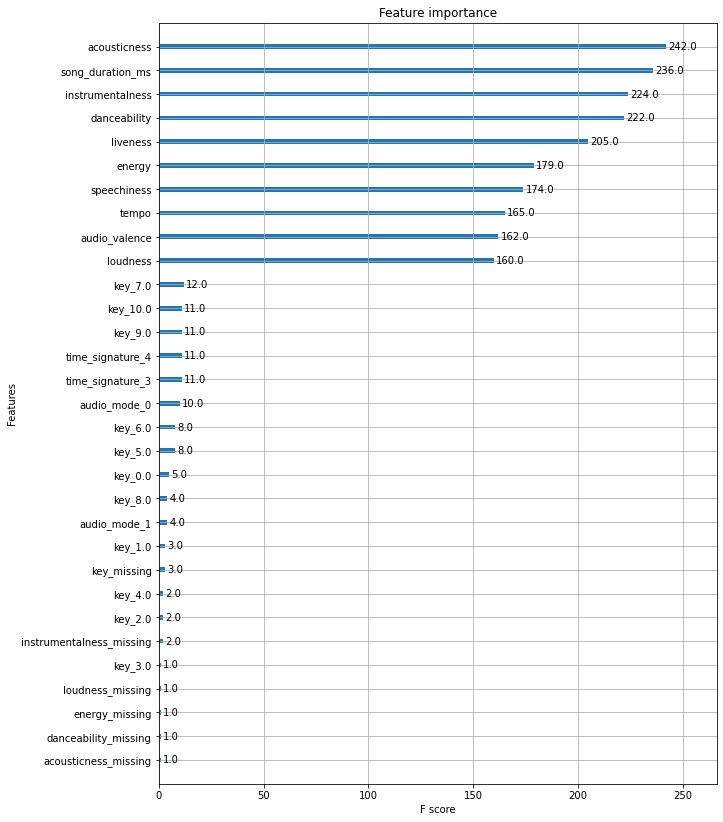

In [76]:
import xgboost
import matplotlib.pyplot as plt

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgboost.plot_importance(booster=booster, ax=ax)

fold_metrics_model_sorted = sorted(fold_metrics_model, key=lambda x:x[0], reverse=True) 
best_model = fold_metrics_model_sorted[0][1]
plot_features(best_model, (10, 14))

In [77]:
# fold_metrics_model_sorted = sorted(fold_metrics_model, key=lambda x:x[0], reverse=True) 

In [78]:
# best_model = fold_metrics_model_sorted[0][1]
# print(best_model)
# X_test = get_input_features(df_test)
# scaler = StandardScaler()
# X_test_scaled = scaler.fit_transform(X_test)
# predictions = best_model.predict(X_test_scaled)
# print(f"Completed prediction for {len(predictions)} test rows")
# df_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')
# df_submission['song_popularity']= predictions
# df_submission.to_csv('submission_lr.csv',index=False)